## Modele

Dane niezbędne do prawidłowego funkcjonowania modelu przygotowywane są dzięki wykorzystaniu mechanizmu `pipeline` z biblioteki `sklearn`. Do wyboru cech (proces ich wybierania przebiega analogicznie jak ten zdefiniowany w *preprocessing_02.ipynb*) służy klasa **FeatureBuilder**. Następnie atrybuty są odpowiednio przetwarzane przez **Preprocessor** - uzupełnia on brakujące wartości i koduje atrybuty. 

Sprawdzone modele to:
1. Model bazowy - **Regresja liniowa**
2. Model docelowy - **Las losowy**

W procesie trenowania modelu używana jest metoda **walidacji krzyżowej**.

#### Setup

In [76]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
from sklearn.pipeline import Pipeline
from src.builder import FeatureBuilder
from src.preprocessor import Preprocessor

#### Wczytanie i przygotwanie odpowiednich danych do pipeline'u ML i ewaluacji modelu 

In [78]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cluster import HDBSCAN
from src.transformations.target import transform_pipeline
import numpy as np

listings = pd.read_csv("../data/listings.csv")
sessions = pd.read_csv("../data/sessions.csv")
target = transform_pipeline(listings["price"])
listings.drop(columns=["price"], inplace=True)

coords_rad = np.radians(listings[["latitude", "longitude"]].to_numpy())
clusterer = HDBSCAN(
    min_cluster_size=15,
    min_samples=1,
    metric="haversine",
    cluster_selection_method="eom",
    copy=False,
)
ids = clusterer.fit_predict(coords_rad)

X = listings
y = target
cv = KFold(n_splits=5, shuffle=True, random_state=42)

### Model bazowy - regresja liniowa

In [79]:
from sklearn.linear_model import LinearRegression

pipe_linear = Pipeline(
    [
        ("builder", FeatureBuilder(sessions)),
        ("preprocessor", Preprocessor()),
        ("regressor", LinearRegression()),
    ]
)

cv_scores = cross_val_score(pipe_linear, X, y, cv=cv, scoring="neg_mean_absolute_error")
mae = -cv_scores

pipe_linear.fit(X, y)

print(f"Mean CV MAE (linear model): {mae.mean():.2f} ± {mae.std():.2f}")

Mean CV MAE (linear model): 38.61 ± 1.91


### Model docelowy - random forest

Początkowo model zostanie dopasowany wykorzystując domyślne parametry biblioteki `sklearn`. Pierwszy fit posłuży wyłącznie do orientacyjnej oceny ważności cech, ponieważ są one w głownej mierze niezależne od hiperparametrów modelu. 

In [80]:
from sklearn.ensemble import RandomForestRegressor

pipe_forest = Pipeline(
    [
        ("builder", FeatureBuilder(sessions)),
        ("preprocessor", Preprocessor()),
        ("regressor", RandomForestRegressor(n_jobs=1)),
    ]
)

cv_scores = cross_val_score(pipe_forest, X, y, cv=cv, scoring="neg_mean_absolute_error")
mae = -cv_scores

pipe_forest.fit(X, y)

print(f"Mean CV MAE (default random forest): {mae.mean():.2f} ± {mae.std():.2f}")

Mean CV MAE (default random forest): 32.61 ± 2.64


#### Feature importance

Wartości *feature importance* zostają wyciągnięte z pipeline'u lasu losowego.

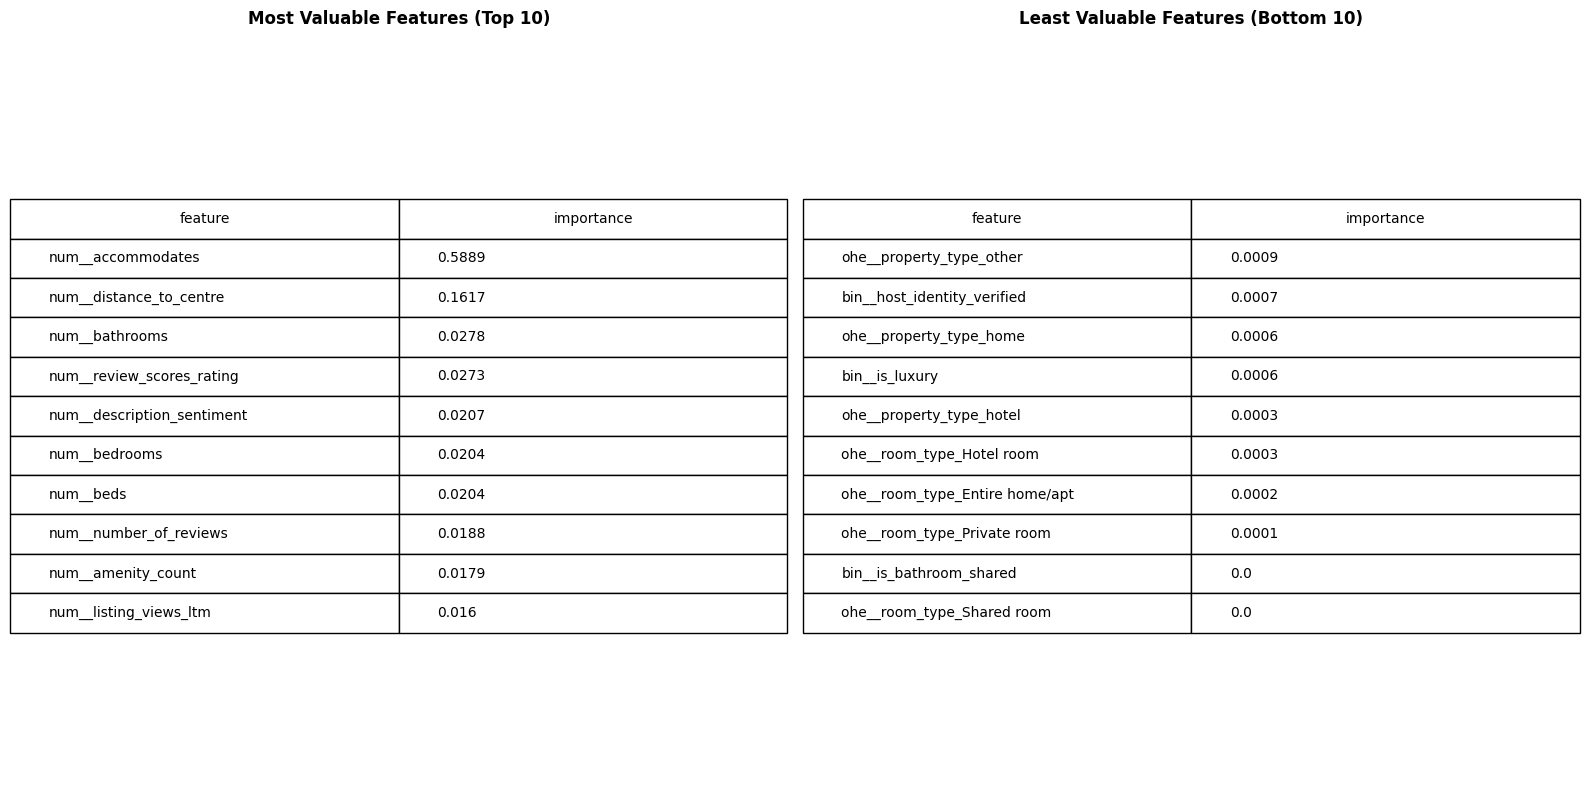

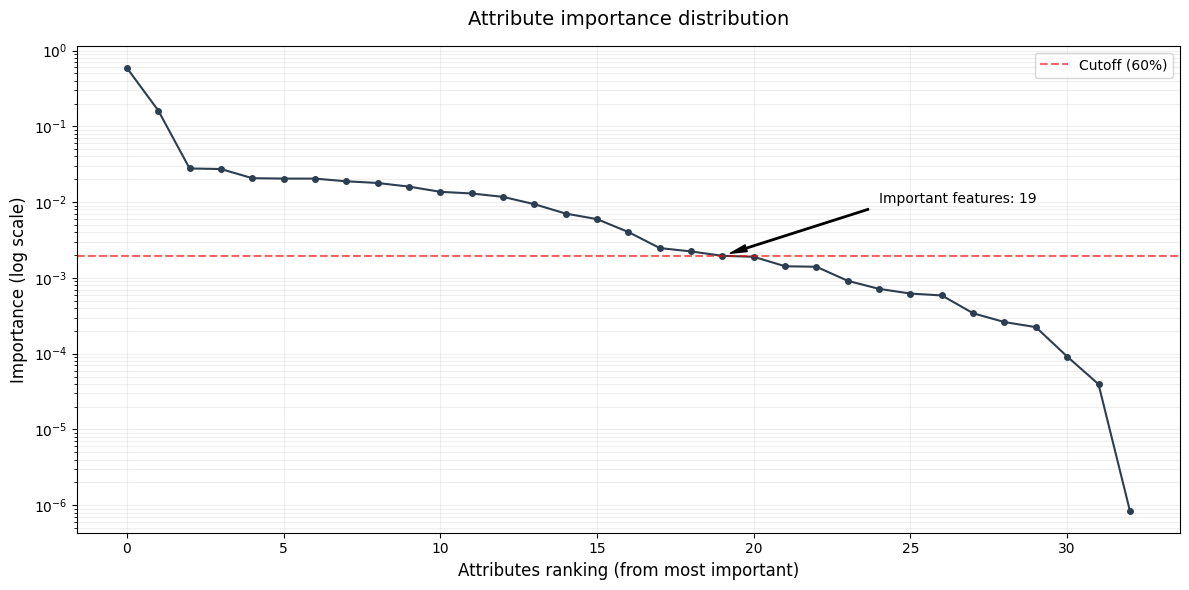

In [81]:
from src.visualizations.feature_importance import visualize_feature_importance_tables, plot_importance_distribution

visualize_feature_importance_tables(pipe_forest)
plot_importance_distribution(pipe_forest)

Jak pokazują powyższe statystyki dla modelu znaczących jest kilkanaście atrybutów, tylko one mają wartości *importance* powyżej niskiego i orientacyjnego progu decyzyjnego jakim jest 0.005. Wobec tego zostanie podjęta próba redukcji atrybutów, tak aby minimalizować skłonności modelu do przeuczenia.

Wartości atrybutów dyskretnych (zakodowane po przez *one-hot-encoding*) zostaną zagregowane - liczona jest suma składowych, która mówi jak bardzo dana cecha jest znacząca.

In [82]:
from src.selector import FeatureSelector

selector = FeatureSelector(
    RandomForestRegressor(n_jobs=1),
    percent=0.6, 
    ohe_features=["room_type", "property_type"]
)

pipe_selector = Pipeline(
    [
        ("builder", FeatureBuilder(sessions)),
        ("preprocessor", Preprocessor()),
        ("selector", selector)
    ]
)

X_reduced = pipe_selector.fit_transform(X, y)
X_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   num__accommodates                     1458 non-null   float64
 1   num__distance_to_centre               1458 non-null   float64
 2   num__review_scores_rating             1458 non-null   float64
 3   num__beds                             1458 non-null   float64
 4   num__bathrooms                        1458 non-null   float64
 5   num__description_sentiment            1458 non-null   float64
 6   num__number_of_reviews                1458 non-null   float64
 7   num__amenity_count                    1458 non-null   float64
 8   num__listing_views_ltm                1458 non-null   float64
 9   num__bedrooms                         1458 non-null   float64
 10  zero__average_booking_duration        1458 non-null   float64
 11  num__neighborhood

In [83]:
forest = RandomForestRegressor(n_jobs=1)

cv_scores = cross_val_score(forest, X_reduced, y, cv=cv, scoring="neg_mean_absolute_error")
mae = -cv_scores

forest.fit(X_reduced, y)

print(f"Mean CV MAE (random forest with cut attribues): {mae.mean():.2f} ± {mae.std():.2f}")

Mean CV MAE (random forest with cut attribues): 32.42 ± 2.37


Jak widać pomimo ograniczenia liczby atrybutów (zachowano 60% najbardziej znaczących) model radzi sobie tak samo dobrze z zadaniem przewidywania ceny, co oznacza, że odrzucone atrybuty były zbędne w procesie uczenia.

In [84]:
df = pd.DataFrame({"feature": X_reduced.columns.values, "importance": forest.feature_importances_})
df

,feature,importance
0,num__accommodates,0.587315
1,num__distance_to_centre,0.159840
2,num__review_scores_rating,0.029423
3,num__beds,0.025742
4,num__bathrooms,0.032783
5,num__description_sentiment,0.020550
6,num__number_of_reviews,0.020547
7,num__amenity_count,0.019431
8,num__listing_views_ltm,0.016492
9,num__bedrooms,0.022435


#### Strojenie hiperparametrów modelu

Do strojenia hiperparametrów wybrano przeszukiwanie na siatce. Zdefiniowanych zostało kilka typowych zestawów atrybutów, które następnie łączone są w kolejne kombinacje, na których ewaluowana jest jakość modelu.

In [85]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 8, 10],
    "min_samples_leaf": [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=forest,
    param_grid=param_grid,
    cv=cv,  
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=0,
    refit=True,
)

grid_search.fit(X_reduced, y)

mse = -grid_search.best_score_
params = grid_search.best_params_

print(f"Best mean CV MAE (random forest) : {mse:.2f}")
print(f"Chosen parameters: {grid_search.best_params_}")

Best mean CV MAE (random forest) : 32.22
Chosen parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


W tym przypadku las losowy wykazuje bardzo małą wrażliwość na strojenie hiperparametrów. Mimo to, wybrane zostały najlepsze, być może wpłyną one pozytywnie na model. 

### Interpretacja wyników

#### Wykresy różnicy ceny danej i przewidzianej:
- Zielona belka - mediana dla klastra
- Środkowa sztabka - 50% środkowych wartości
- Knoty świec - skrajne predykcje

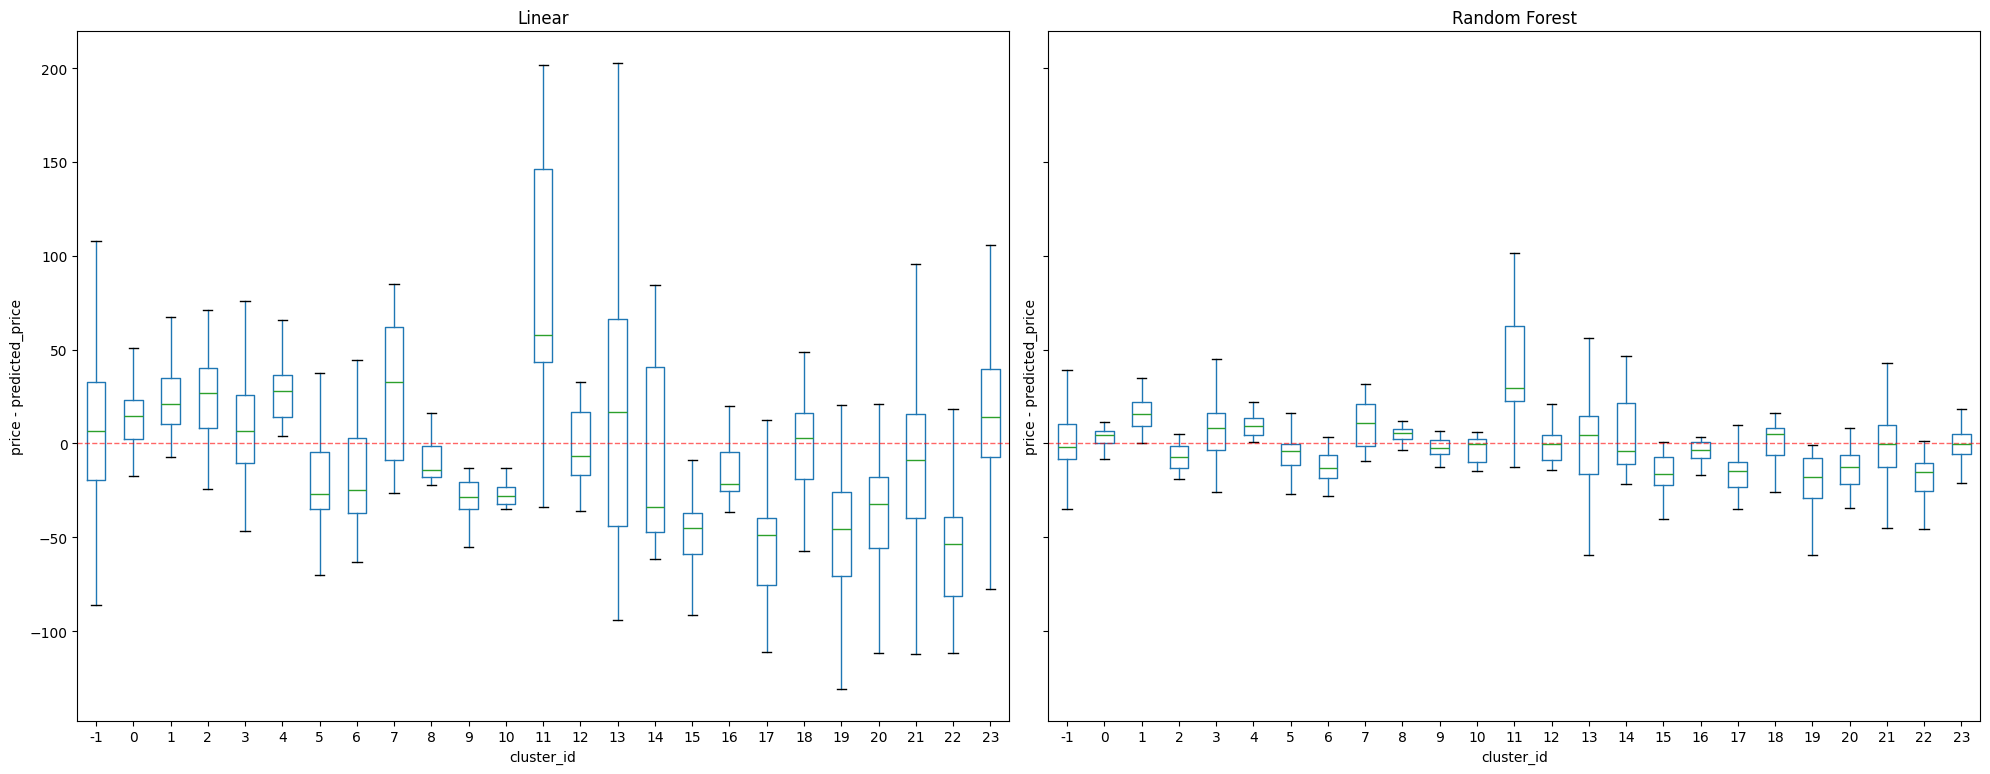

In [86]:
from src.visualizations.results import visualize_results_compare, visualize_map

pred_linear = pipe_linear.predict(X)
pred_rf = grid_search.best_estimator_.predict(X_reduced)

diff_linear = y -pred_linear
diff_rf = y - pred_rf 
visualize_results_compare(diff_linear, diff_rf, ids)

Interpretacja map
- Kolor zielony - zbyt mało ofert w regionie
- Kolor czerwony - zbyt dużo ofert w regionie

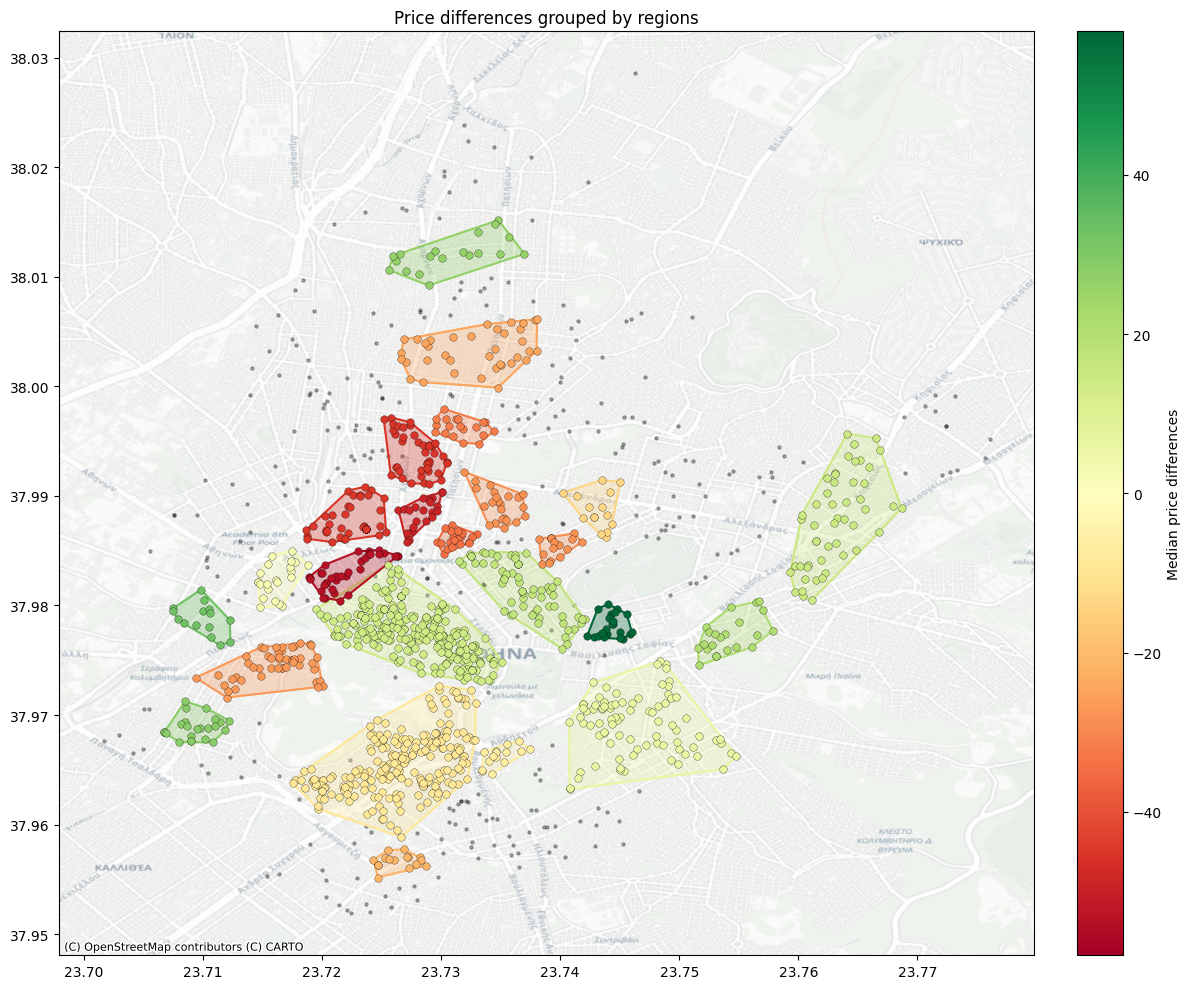

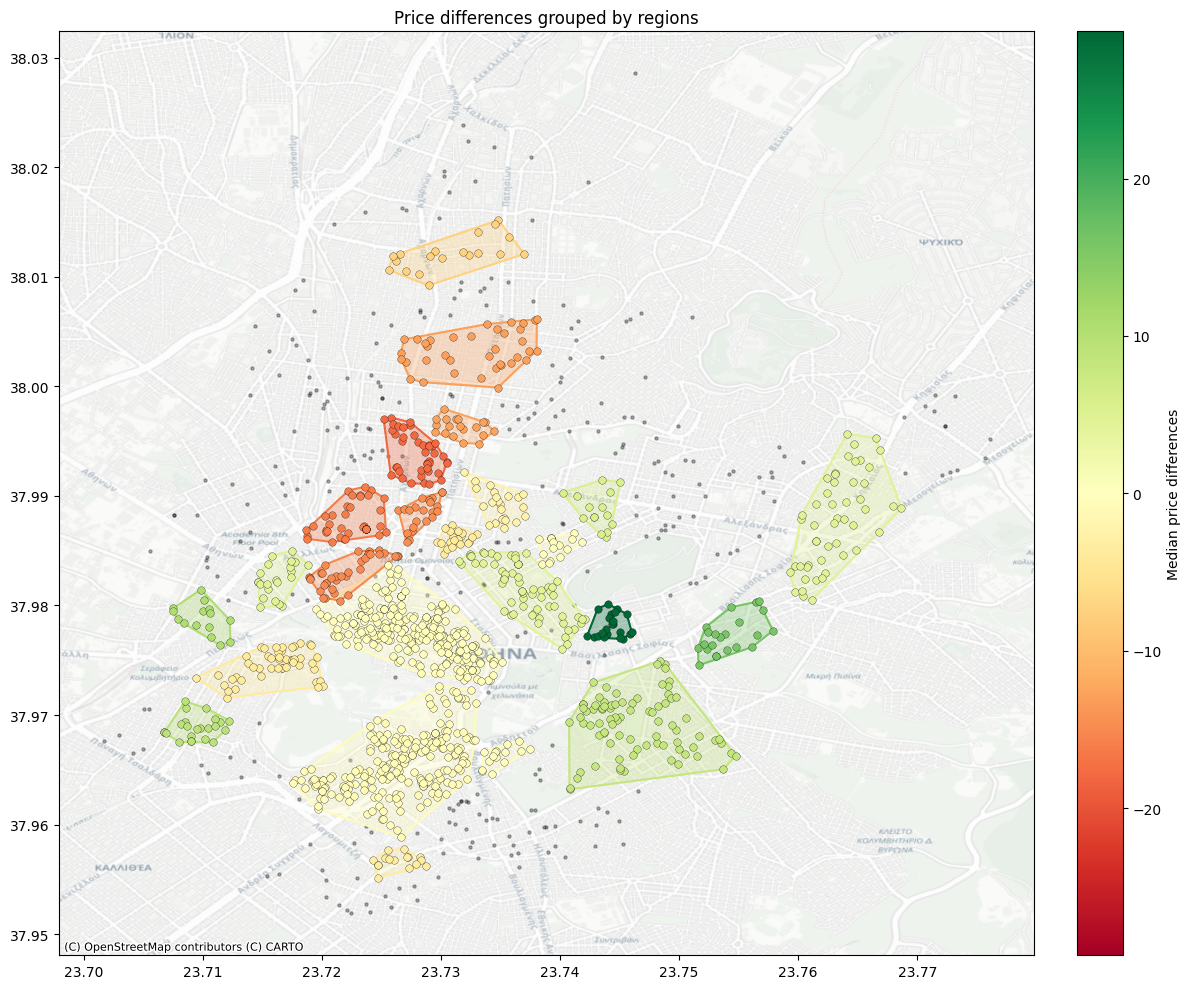

In [87]:
visualize_map(diff_linear, ids, listings)
visualize_map(diff_rf, ids, listings)

#### Zapisanie modelów do plików

In [88]:
import joblib
from pathlib import Path

models_dir = Path("../models")
models_dir.mkdir(exist_ok=True, parents=True)

joblib.dump(pipe_linear, models_dir / "linear_pipeline.joblib")
joblib.dump(forest, models_dir / "forest.joblib")
joblib.dump(selector, models_dir / "selector_pipeline.joblib")

['../models/selector_pipeline.joblib']

## Wnioski

1. **Błąd MAE** podczas uczenia modelu - różnica wartości między błędu między modelami jest niewielka. Nie mówi jasno czy stosowanie lasu losowego jest konieczne.
2. **Mapy** - wyniki dla obydwu modeli są stosunkowo podobne, trzeba się dobrze przyjrzeć, żeby zobaczyć różnicę.
3. **Wykresy statystyczne** - znacząco różnią się od siebie. Dla modelu regresji liniowej wyniki są bardziej skrajne, model nie jest w stanie wychwycić nieliniowych zależności, co prowadzi do bardzo dużych różnic predykcji w obrębie jednego klastra. Natomiast wyniki lasu losowego są bardziej stabilne, jest on w stanie dostrzec trudniejsze zależności, co przekłada się na mniej zaszumione wyniki.

Obserwacje wskazują, że w analizowanym problemie szukania regionów, w których liczba ofert jest zbyt duża **jest adekwatne** zastosowanie bardziej zaawansowanego modelu **lasu losowego**.